# Flare Flux Budget

In [1]:
import pathlib
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support, ImageNormalize, LogStretch, AsymmetricPercentileInterval
from astropy.convolution import convolve, Gaussian1DKernel
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate
import fiasco

from fiasco.io import Parser
from synthesizAR.instruments import InstrumentDEM

from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response, ThinFilmFilter

%matplotlib inline

Set up flare DEM from CHIANTI

In [2]:
def dem_table_to_ndcube(dem_table):
    temperature = dem_table['temperature_bin_center']
    em = dem_table['dem']*np.gradient(temperature, edge_order=2)
    tab_coord = QuantityTableCoordinate(temperature,
                                        names='temperature',
                                        physical_types='phys.temperature')
    return ndcube.NDCube(em, wcs=tab_coord.wcs, meta=dem_table.meta)

In [3]:
tab_flare = Parser('flare.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
dem_flare = dem_table_to_ndcube(tab_flare)
tab_flare_ext = Parser('flare_ext.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
dem_flare_ext = dem_table_to_ndcube(tab_flare_ext)
tab_ar = Parser('active_region.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse()
dem_ar = dem_table_to_ndcube(tab_ar)

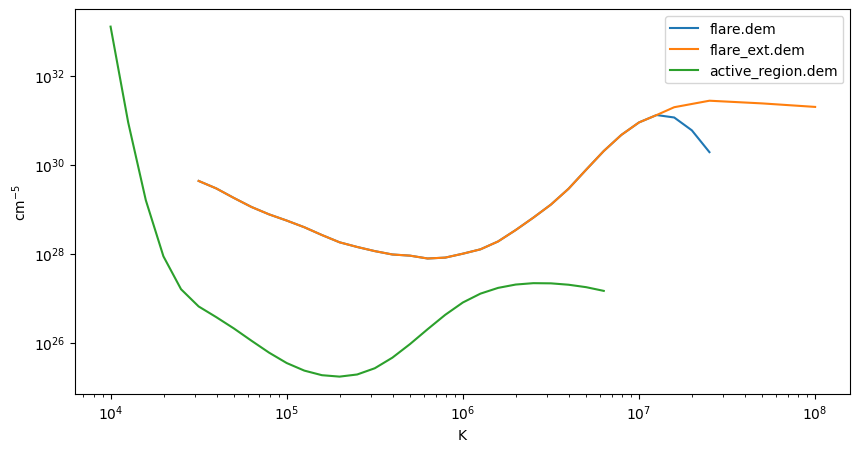

In [4]:
plt.figure(figsize=(10, 5))
with quantity_support():
    plt.plot(dem_flare.axis_world_coords(0)[0], dem_flare.data*dem_flare.unit, label='flare.dem')
    plt.plot(dem_flare_ext.axis_world_coords(0)[0], dem_flare_ext.data*dem_flare_ext.unit, label='flare_ext.dem')
    plt.plot(dem_ar.axis_world_coords(0)[0], dem_ar.data*dem_ar.unit, label='active_region.dem')
plt.xscale('log')
plt.yscale('log')
plt.legend()

Get spectra 

In [5]:
spec_tables = get_spectral_tables()

Set up instrument response

In [6]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')

In [7]:
chan = SpectrogramChannel(1, al_filter)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


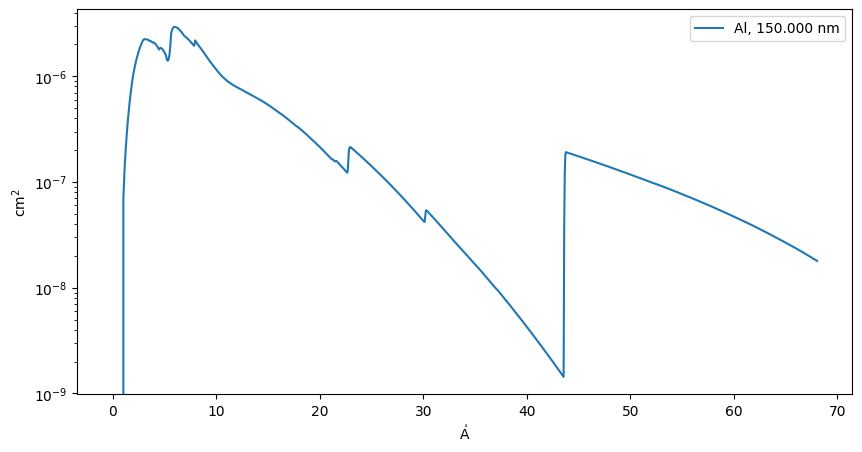

In [8]:
plt.figure(figsize=(10,5))
with quantity_support():
    plt.plot(chan.wavelength, chan.effective_area, label=chan.filter_label)
plt.yscale('log')
plt.legend()

Compute spectrum

In [9]:
intensity_flare = InstrumentDEM.calculate_intensity(dem_flare, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
intensity_flare_ext = InstrumentDEM.calculate_intensity(dem_flare_ext, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
intensity_ar = InstrumentDEM.calculate_intensity(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
flux_flare = convolve_with_response(intensity_flare, chan, electrons=False, include_gain=False)
flux_flare_ext = convolve_with_response(intensity_flare_ext, chan, electrons=False, include_gain=False)
flux_ar = convolve_with_response(intensity_ar, chan, electrons=False, include_gain=False)

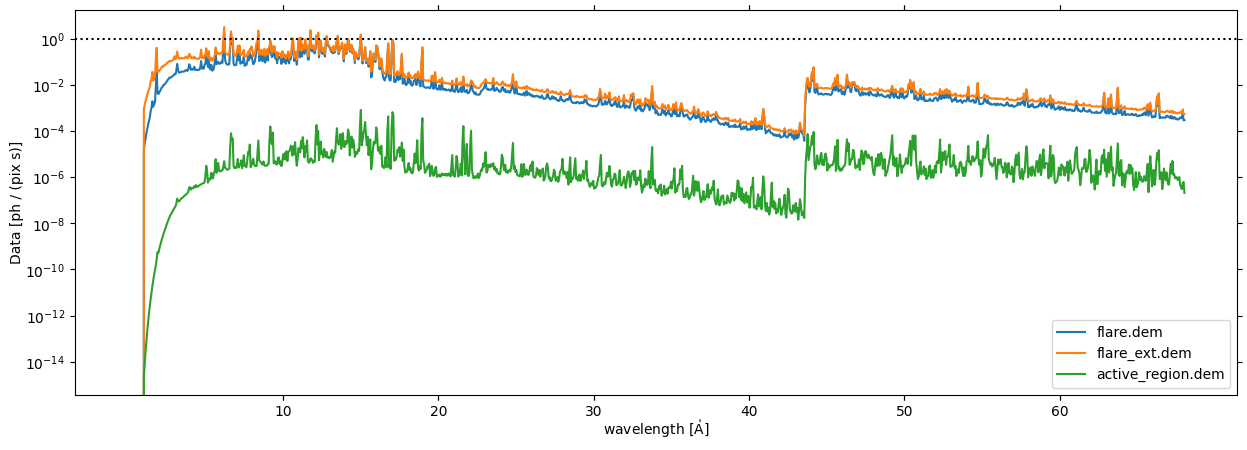

In [10]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare)
flux_flare.plot(axes=ax, label='flare.dem')
flux_flare_ext.plot(axes=ax, label='flare_ext.dem')
flux_ar.plot(axes=ax, label='active_region.dem')
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

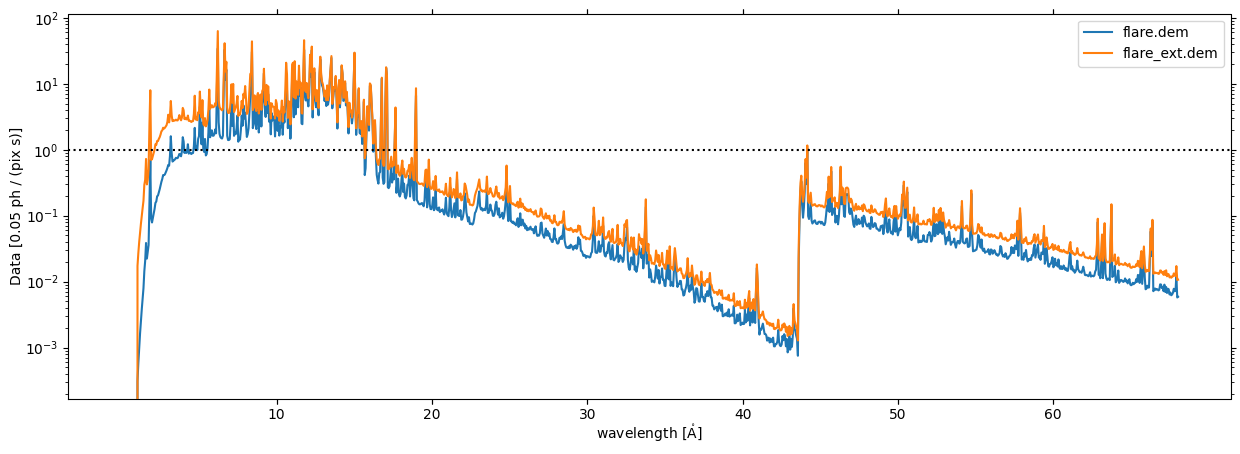

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare)
flux_flare.plot(axes=ax, label='flare.dem', data_unit=u.ph / u.pix / (20 * u.s))
flux_flare_ext.plot(axes=ax, label='flare_ext.dem', data_unit=u.ph / u.pix / (20 * u.s))
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

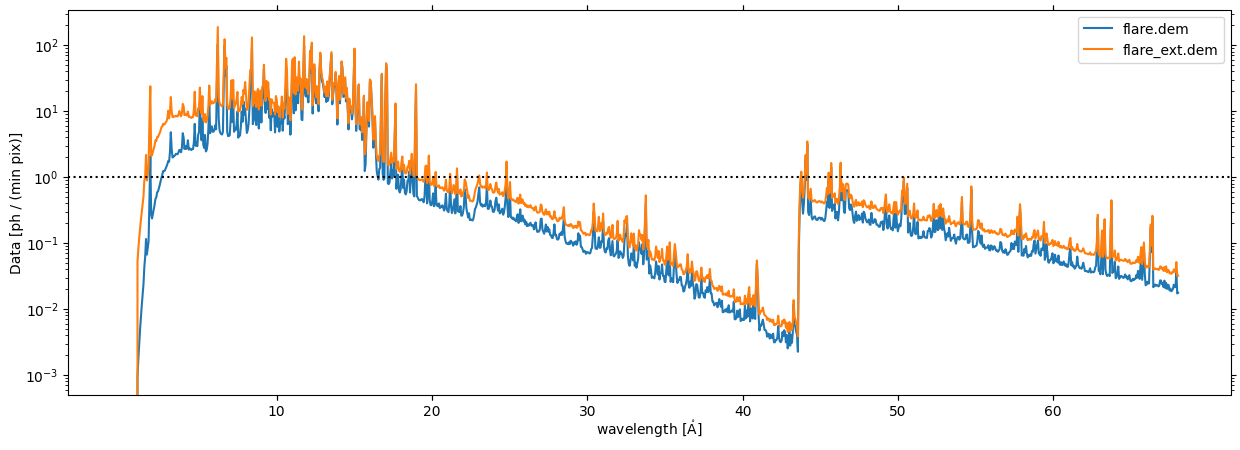

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare)
flux_flare.plot(axes=ax, label='flare.dem', data_unit=u.ph / u.pix /  u.minute)
flux_flare_ext.plot(axes=ax, label='flare_ext.dem', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.axhline(y=1, color='k', ls=':')
ax.legend()

What about losses in spectral resolution?

In [13]:
def degrade_spectra(spec, resolution):
    std = resolution / (2*np.sqrt(2*np.log(2)))  # FWHM is 0.5 so convert to sigma using W = 2\sqrt{2\ln2}\sigma
    std_eff = (std / chan.spectral_resolution).to_value('pix')  # Scale sigma by bin width
    kernel = Gaussian1DKernel(std_eff)
    data_smooth = convolve(spec.data, kernel)
    return ndcube.NDCube(data_smooth, wcs=spec.wcs, meta=spec.meta, unit=spec.unit)

In [14]:
flux_05 = degrade_spectra(flux_flare_ext, 0.5*u.angstrom)
flux_10 = degrade_spectra(flux_flare_ext, 1*u.angstrom)

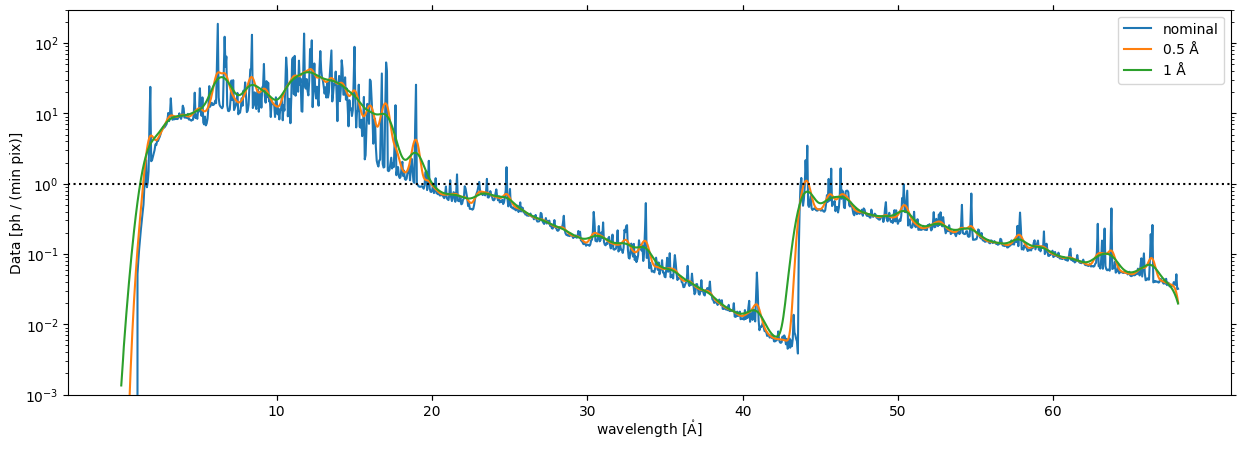

In [15]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
ax.legend()

Looking at particular lines

In [16]:
line_ids = [
    ('Fe XVIII',14.21*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 15.01*u.angstrom),  # also targeted by MaGIXS
    ('Fe XVII', 16.78*u.AA),
    ('Fe XVII', 17.05*u.AA),
    ('O VII', 21.60*u.angstrom),  # also targeted by MaGIXS
    ('O VII', 21.81*u.angstrom),
    ('O VII', 22.10*u.AA),
    ('O VIII', 18.97*u.angstrom),  # also targeted by MaGIXS
    ('Fe XXV', 1.86*u.AA),
    ('Ca XIX', 3.21*u.AA),
    ('Si XIII', 6.74*u.AA),
    ('Mg XI', 9.32*u.AA),
    ('Fe XVII', 11.25*u.AA),
    ('Fe XX', 12.83*u.AA),
    ('Ne IX', 13.45*u.AA),
    ('Fe XIX', 13.53*u.AA),
    ('C VI', 33.73*u.AA),
    ('C V', 40.27*u.AA),
    ('Si XII', 44.16*u.AA),
    ('Si XI', 49.18*u.AA),
]

In [17]:
def add_line_ids_to_axis(ax, line_ids, rotation=90):
    for ion,line in line_ids:
        ax.axvline(x=ax.wcs.world_to_pixel(line), ls=':', color='k',)
    ax2 = ax.secondary_xaxis('top') 
    ax2.set_xticks(ax.wcs.world_to_pixel(u.Quantity([l for _,l in line_ids])),
                   labels=[f'{ion}, {line.to_string(format="latex_inline")}' for ion,line in line_ids],
                   rotation=rotation,
                   horizontalalignment='center',
                   #verticalalignment='center'
                  )

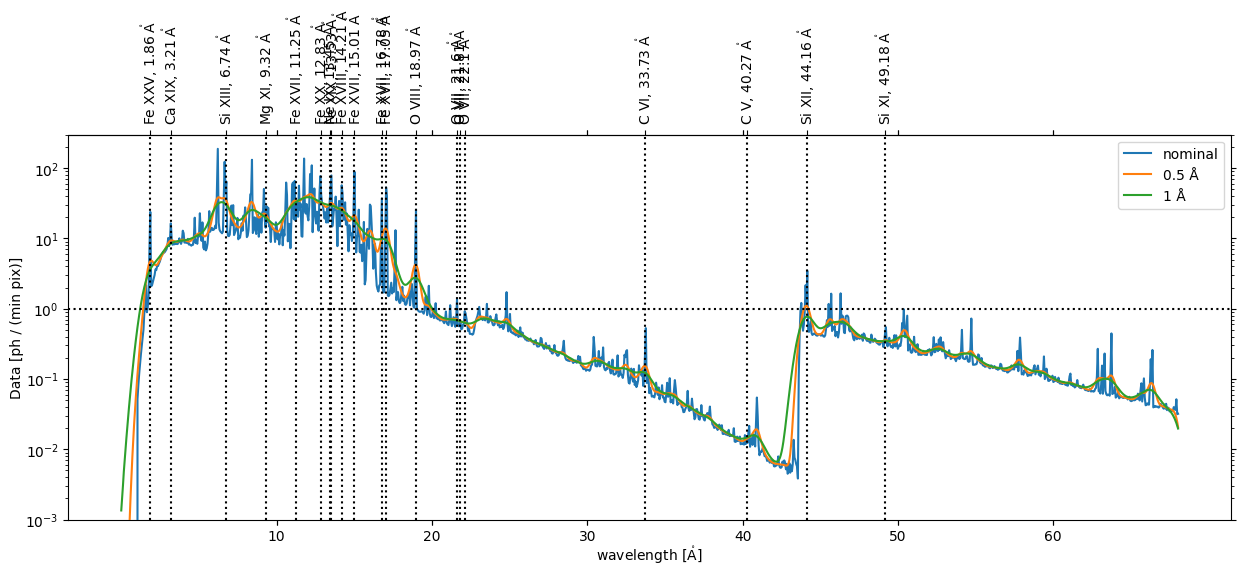

In [19]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
ax.legend()
add_line_ids_to_axis(ax, line_ids)
#ax.set_xlim(ax.wcs.world_to_pixel([14,23]*u.angstrom))

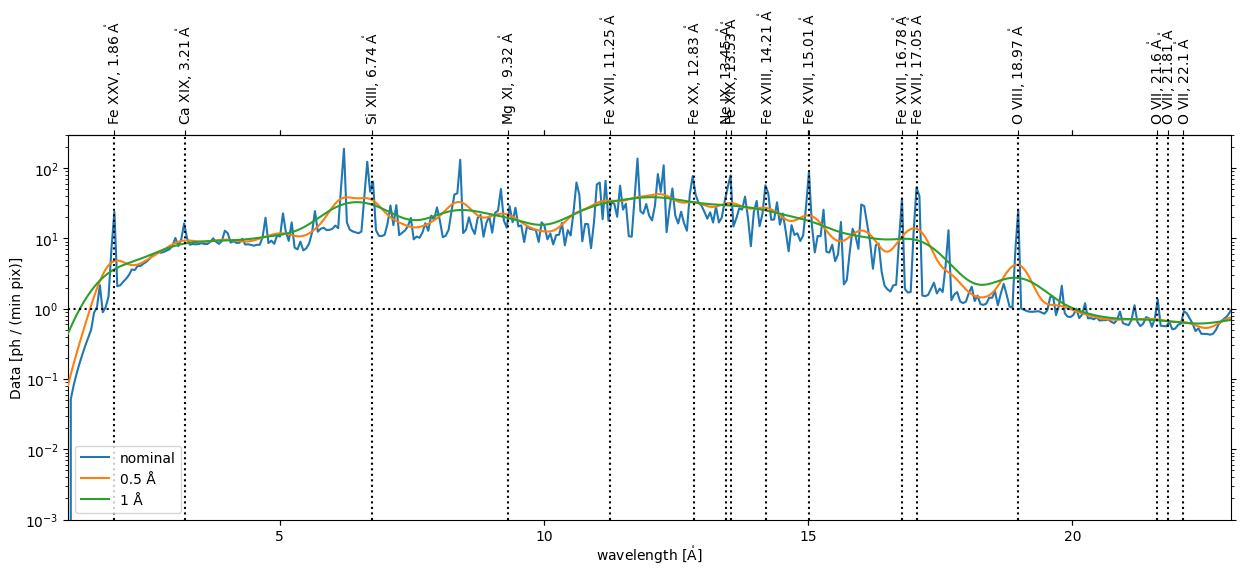

In [20]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
add_line_ids_to_axis(ax, line_ids)
ax.set_xlim(ax.wcs.world_to_pixel([1,23]*u.angstrom))
ax.legend(loc=3)

(254.54545454545456, 418.18181818181824)

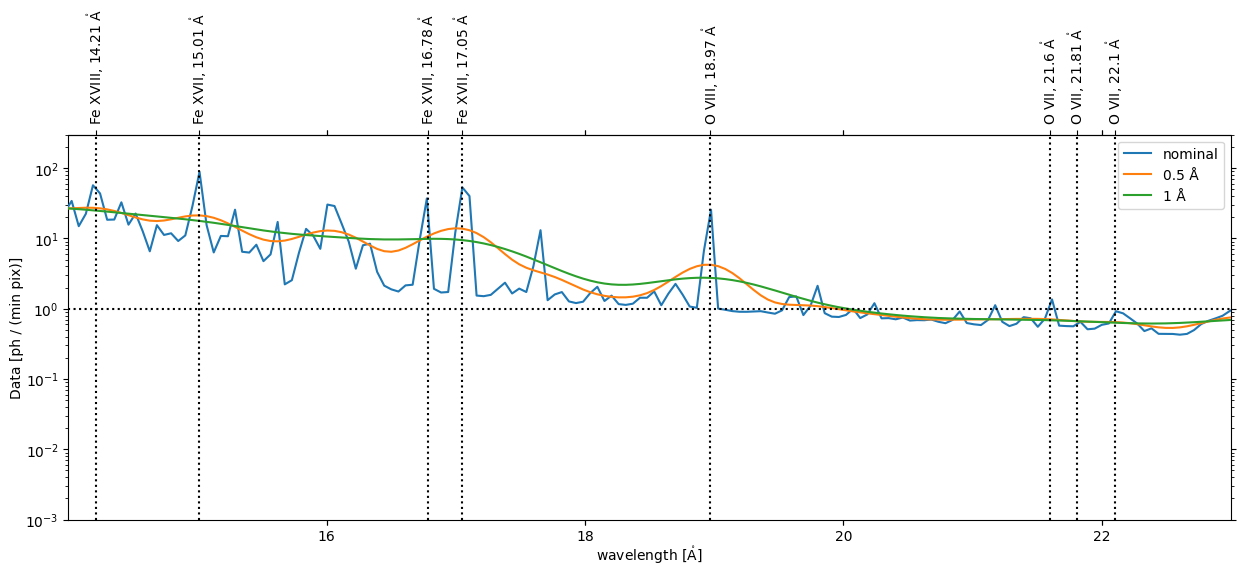

In [18]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
ax.legend()
add_line_ids_to_axis(ax, line_ids)
ax.set_xlim(ax.wcs.world_to_pixel([14,23]*u.angstrom))

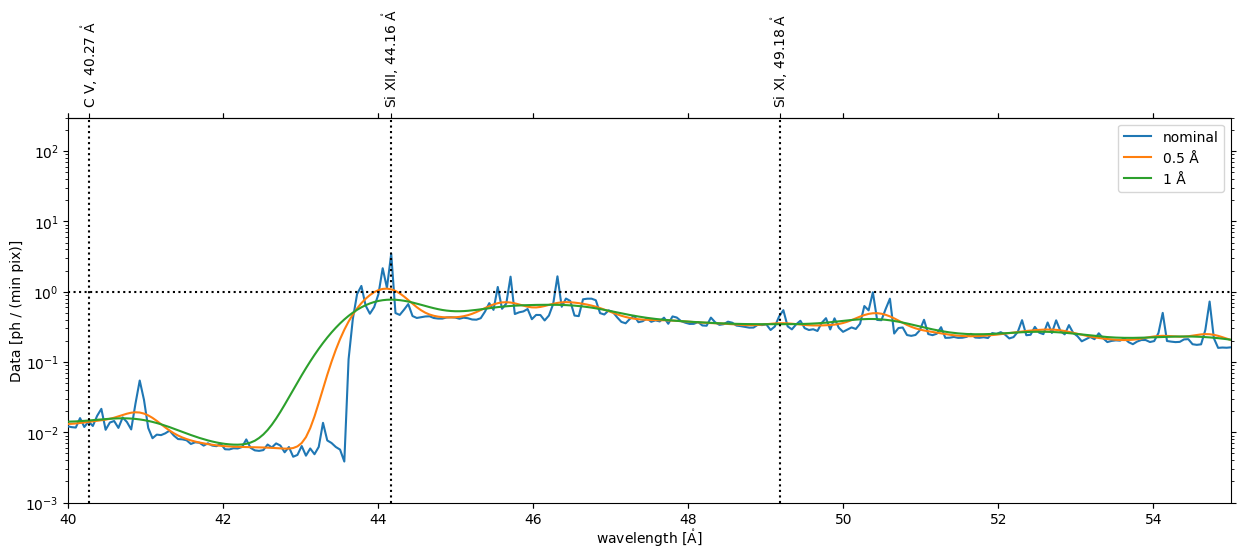

In [21]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=flux_flare_ext)
flux_flare_ext.plot(axes=ax, label='nominal', data_unit=u.ph / u.pix / u.minute)
flux_05.plot(axes=ax, label='0.5 Å', data_unit=u.ph / u.pix / u.minute)
flux_10.plot(axes=ax, label='1 Å', data_unit=u.ph / u.pix / u.minute)
ax.set_yscale('log')
ax.set_ylim(1e-3, 3e2)
ax.axhline(y=1, color='k', ls=':')
add_line_ids_to_axis(ax, line_ids)
ax.set_xlim(ax.wcs.world_to_pixel([40,55]*u.angstrom))
ax.legend(loc=1)